In [8]:
#Loading necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from functools import reduce
from collections import Counter
import re
import nltk
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
from nltk.corpus import stopwords as nltk_stopwords

In [3]:
#Loading datasets
anime_df = pd.read_csv('../datasets/animes_with_synopsis_cleaned.csv')
ratings_df = np.load('../datasets/ratings.npy', allow_pickle=True) # returns a numpy array

In [5]:
anime_df.head()

,animeID,title,alternative_title,type,year,score,episodes,mal_url,sequel,image_url,genres,genres_detailed,synopsis
0,1,Howl's Moving Castle,Howl no Ugoku Shiro,MOVIE,2004,8.41,1,https://myanimelist.net/anime/431,False,https://cdn.myanimelist.net/images/anime/1470/...,"['Adventure', 'Award Winning', 'Drama', 'Fanta...","['action', 'adventure', 'age gap', 'air force'...","That jumbled piece of architecture, that cacop..."
1,2,Death Note,NaN,TV,2006,8.63,37,https://myanimelist.net/anime/1535,False,https://cdn.myanimelist.net/images/anime/1079/...,"['Supernatural', 'Suspense']","['achronological order', 'acting', 'adapted in...","Brutal murders, petty thefts, and senseless vi..."
2,3,Problem Children Are Coming from Another World...,Mondaiji-tachi ga Isekai kara Kuru Sou desu yo?,TV,2013,7.42,10,https://myanimelist.net/anime/15315,False,https://cdn.myanimelist.net/images/anime/12/43...,"['Action', 'Comedy', 'Fantasy']","['action', 'alternative world', 'anthropomorph...","Izayoi Sakamaki, Asuka Kudou, and You Kasukabe..."
3,4,BTOOOM!,Btooom!,TV,2012,7.34,12,https://myanimelist.net/anime/14345,False,https://cdn.myanimelist.net/images/anime/4/409...,"['Action', 'Sci-Fi', 'Suspense']","['achronological order', 'action', 'adventure'...",Ryouta Sakamoto is unemployed and lives with h...
4,5,Sword Art Online,NaN,TV,2012,7.5,25,https://myanimelist.net/anime/11757,False,https://cdn.myanimelist.net/images/anime/11/39...,"['Action', 'Adventure', 'Fantasy', 'Romance']","['action', 'action drama', 'adventure', 'alter...",Ever since the release of the innovative Nerve...


In [9]:
print(anime_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20237 entries, 0 to 20236
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   animeID            20237 non-null  int64 
 1   title              20237 non-null  object
 2   alternative_title  8676 non-null   object
 3   type               20237 non-null  object
 4   year               20237 non-null  object
 5   score              20237 non-null  object
 6   episodes           20237 non-null  int64 
 7   mal_url            20237 non-null  object
 8   sequel             20237 non-null  bool  
 9   image_url          20237 non-null  object
 10  genres             20237 non-null  object
 11  genres_detailed    20237 non-null  object
 12  synopsis           19558 non-null  object
dtypes: bool(1), int64(2), object(10)
memory usage: 1.9+ MB
None


Missing Data Summary for anime_df:
                   Missing Values  Percentage
alternative_title           11561   57.128033
synopsis                      679    3.355240


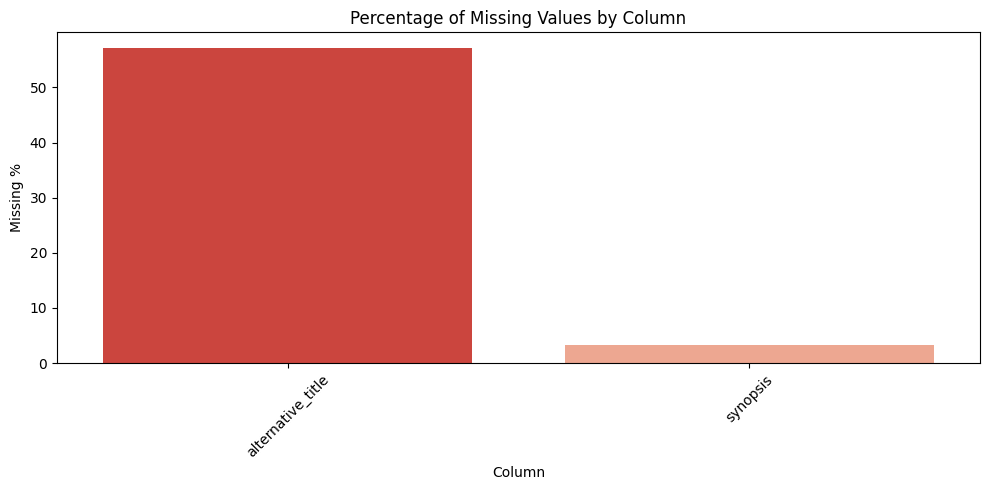

In [25]:
missing_data = anime_df.isnull().sum()
missing_pct = (missing_data / len(anime_df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_data,
    'Percentage': missing_pct
}).sort_values('Percentage', ascending=False)

print("Missing Data Summary for anime_df:")
missing_with_values = missing_df[missing_df['Missing Values'] > 0]
print(missing_with_values)

# Visualize missing data
if len(missing_with_values) > 0:
    plt.figure(figsize=(10, 5))
    sns.barplot(x=missing_with_values.index, y=missing_with_values['Percentage'], palette='Reds_r',hue=missing_with_values.index ,legend=False)
    plt.title('Percentage of Missing Values by Column')
    plt.xlabel('Column')
    plt.ylabel('Missing %')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [8]:
print(type(anime_df["genres"][0]))  # Check the type of the entries in the 'genres' column
genres_series = (anime_df["genres"]
                 .dropna()
                 .str.strip("[]")  
                 .str.split(', ')  
                 .explode()        
                 .str.strip("'"))

<class 'str'>


In [6]:
print("Empty genre count:", (genres_series == '').sum())
print("Sample entries with empty genres:")
print(anime_df[anime_df["genres"].str.contains("'', ", na=False)]["genres"].head())

genres_series = (anime_df["genres"]
                 .dropna()
                 .str.strip("[]")  
                 .str.split(', ')  
                 .explode()        
                 .str.strip("'")
                 .replace('', pd.NA)  # replace empty strings with NA
                 .dropna())            #drop NA values

Empty genre count: 256
Sample entries with empty genres:
Series([], Name: genres, dtype: object)



Anime Type Distribution:
type
TV         5766
SPECIAL    4847
OVA        3661
MOVIE      3250
ONA        2713
Name: count, dtype: int64


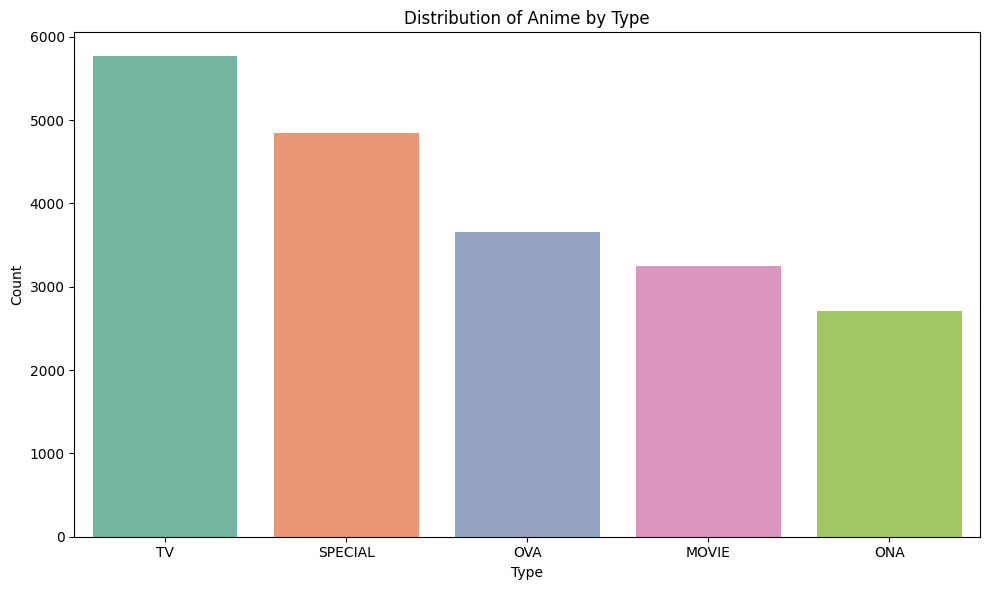

In [10]:
# Anime Type Distribution
type_counts = anime_df['type'].value_counts()
print("\nAnime Type Distribution:")
print(type_counts)

plt.figure(figsize=(10, 6))
sns.barplot(x=type_counts.index, y=type_counts.values, palette='Set2', hue=type_counts.index)
plt.title('Distribution of Anime by Type')
plt.xlabel('Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

genres count: 22


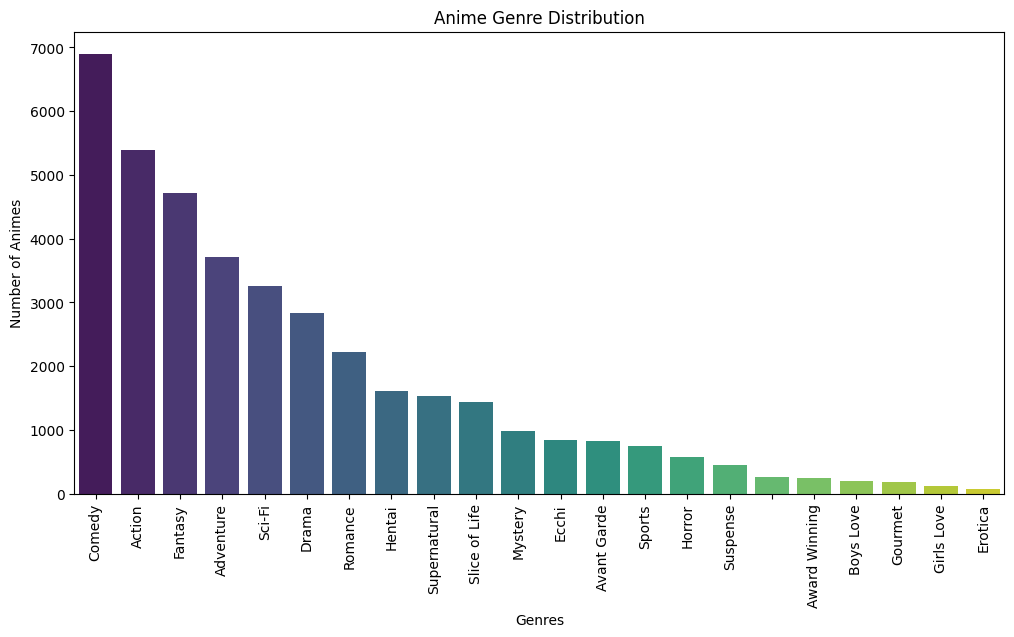

In [12]:
print("genres count:", genres_series.nunique())
genre_counts = genres_series.value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis',hue = genre_counts.index)
plt.xticks(rotation=90)
plt.title('Anime Genre Distribution')
plt.xlabel('Genres')
plt.ylabel('Number of Animes')
plt.show()

detailed genres count: 2990


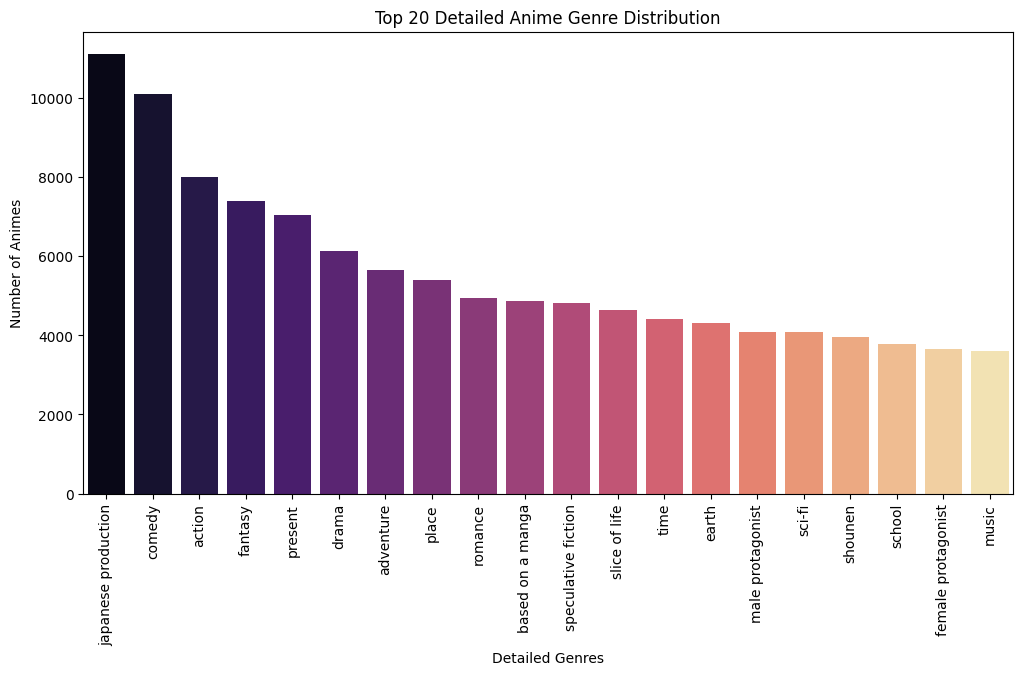

In [13]:
#detailed geres analysis
genres_series = (anime_df["genres_detailed"]
                 .dropna()
                 .str.strip("[]")  
                 .str.split(', ')  
                 .explode()        
                 .str.strip("'"))
genres_series = pd.Series(genres_series)
print("detailed genres count:", genres_series.nunique())
genre_counts = genres_series.value_counts().head(20)
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='magma',hue = genre_counts.index)
plt.xticks(rotation=90)
plt.title('Top 20 Detailed Anime Genre Distribution')
plt.xlabel('Detailed Genres')   
plt.ylabel('Number of Animes')
plt.show()


In [14]:
ratings_df = pd.DataFrame(ratings_df, columns=['user_id', 'anime_id', 'rating'])

#Recasting to more memory efficient dtypes
ratings_df['user_id'] = ratings_df['user_id'].astype('int32')
ratings_df['anime_id'] = ratings_df['anime_id'].astype('int16')  
ratings_df['rating'] = ratings_df['rating'].astype('int8')

print(ratings_df.memory_usage(deep=True))
print(ratings_df.info())
ratings_df.head()

Index             132
user_id     592681984
anime_id    296340992
rating      148170496
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148170496 entries, 0 to 148170495
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int32
 1   anime_id  int16
 2   rating    int8 
dtypes: int16(1), int32(1), int8(1)
memory usage: 989.1 MB
None


,user_id,anime_id,rating
0,1,1,10
1,1,2,10
2,1,3,7
3,1,4,10
4,1,5,10


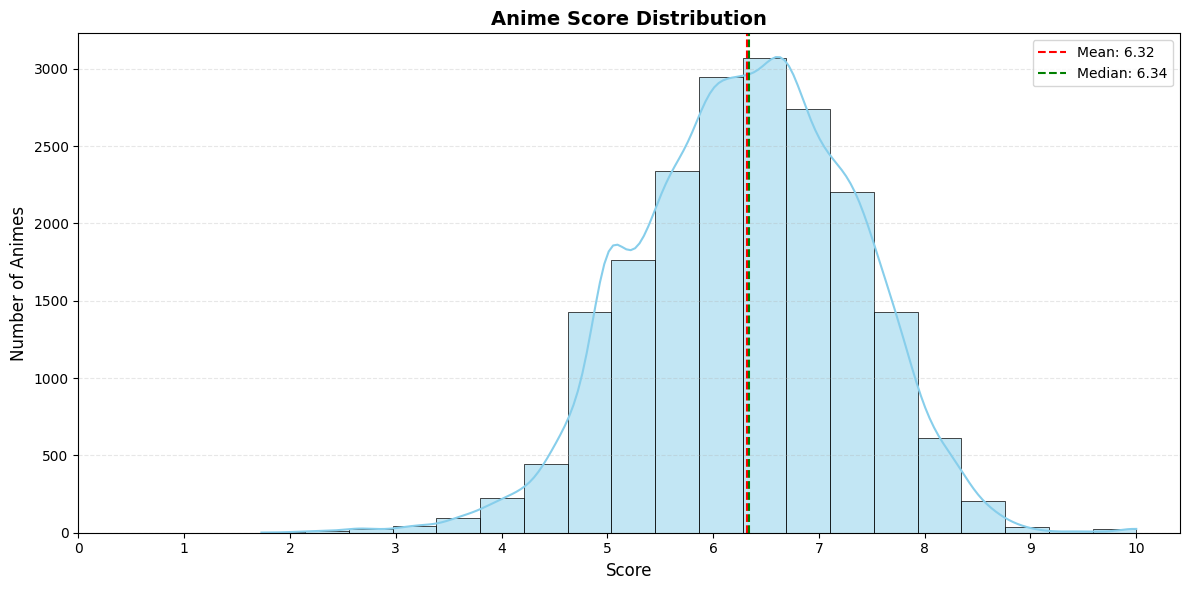

In [37]:
# Score distribution
score_series = anime_df['score'].dropna().apply(pd.to_numeric, errors='coerce').dropna()
results = {
    "mean" : score_series.mean(),
    "median" : score_series.median()
}
# Score distribution
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(score_series, bins=20, kde=True, 
             color='skyblue', edgecolor='black', linewidth=0.5, ax=ax)
ax.axvline(results['mean'], color='red', linestyle='--', label=f'Mean: {results["mean"]:.2f}')
ax.axvline(results['median'], color='green', linestyle='--', label=f'Median: {results["median"]:.2f}')
ax.set_title('Anime Score Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('Score', fontsize=12)
ax.set_ylabel('Number of Animes', fontsize=12)
ax.set_xticks(np.arange(0, 11, 1))
ax.legend()
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

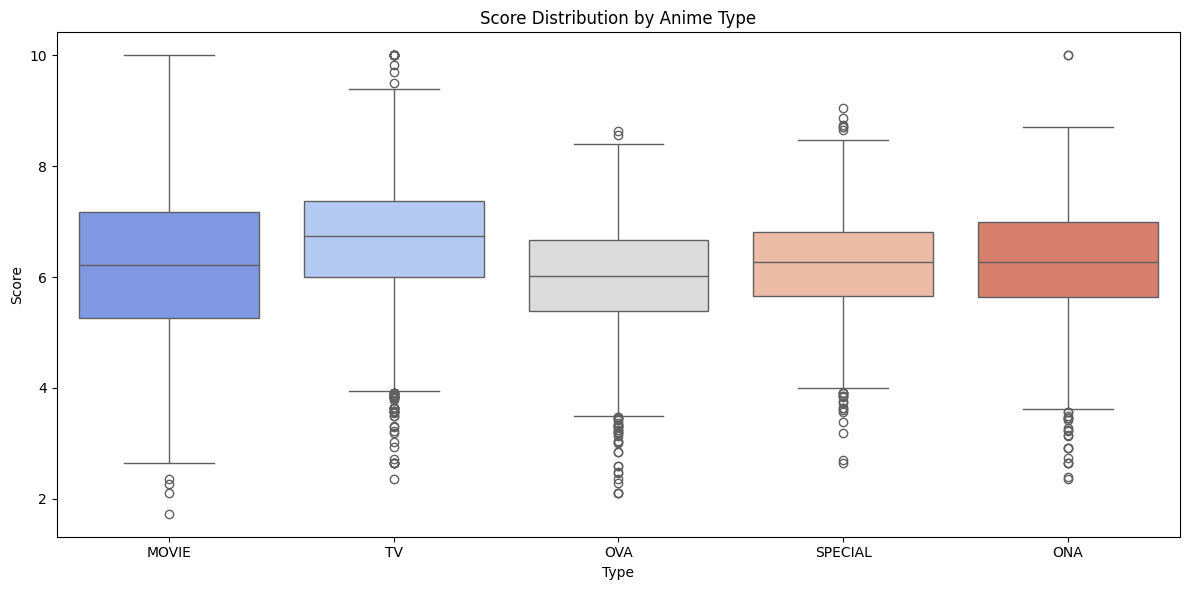

In [31]:
anime_df['score_numeric'] = pd.to_numeric(anime_df['score'], errors='coerce')
plt.figure(figsize=(12, 6))
data_for_box = anime_df.dropna(subset=['score_numeric', 'type'])
sns.boxplot(data=data_for_box, x='type', y='score_numeric', palette='coolwarm',hue = 'type',legend=False)
plt.title('Score Distribution by Anime Type')
plt.xlabel('Type')
plt.ylabel('Score')
plt.tight_layout()
plt.show()

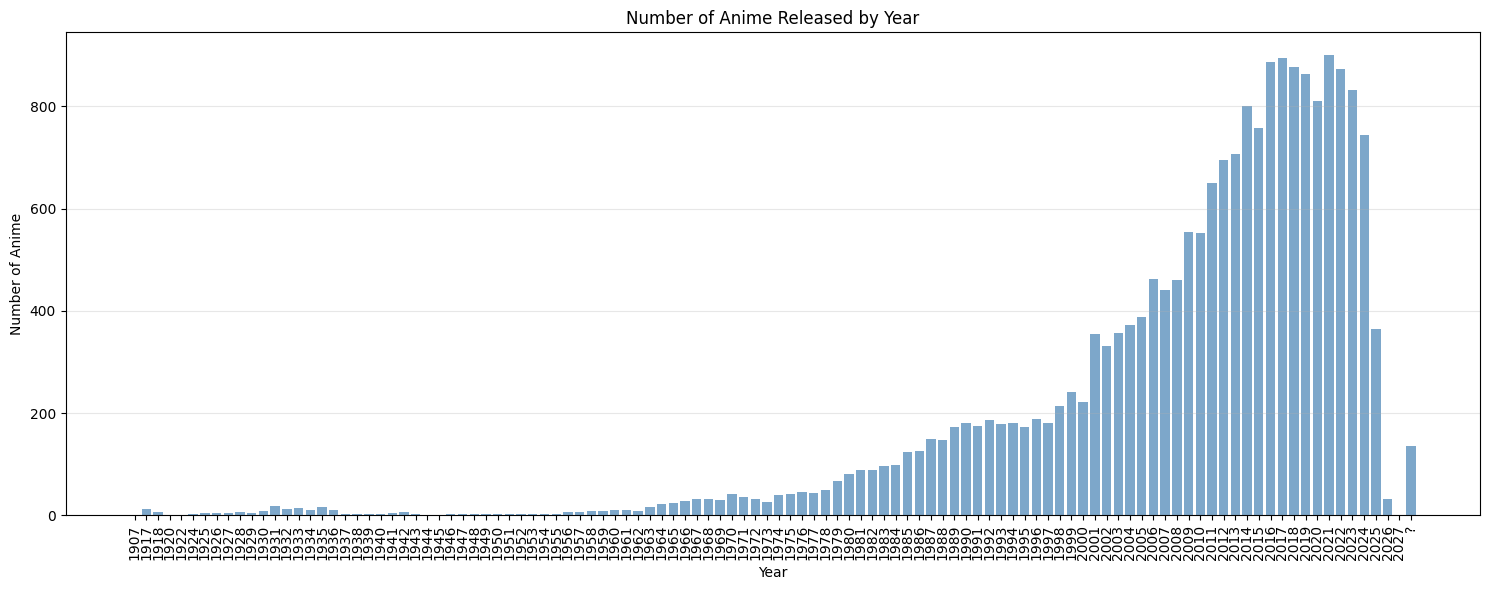

In [ ]:
# Anime Per Year
year_counts = anime_df['year'].dropna().value_counts().sort_index()
plt.figure(figsize=(15, 6))
plt.bar(year_counts.index, year_counts.values, color='steelblue', alpha=0.7)
plt.title('Number of Anime Released by Year')
plt.xlabel('Year')
plt.ylabel('Number of Anime')
plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

   year     score
0  1907  5.450000
1  1917  4.730000
2  1918  4.836667
3  1920  4.450000
4  1922  6.600000


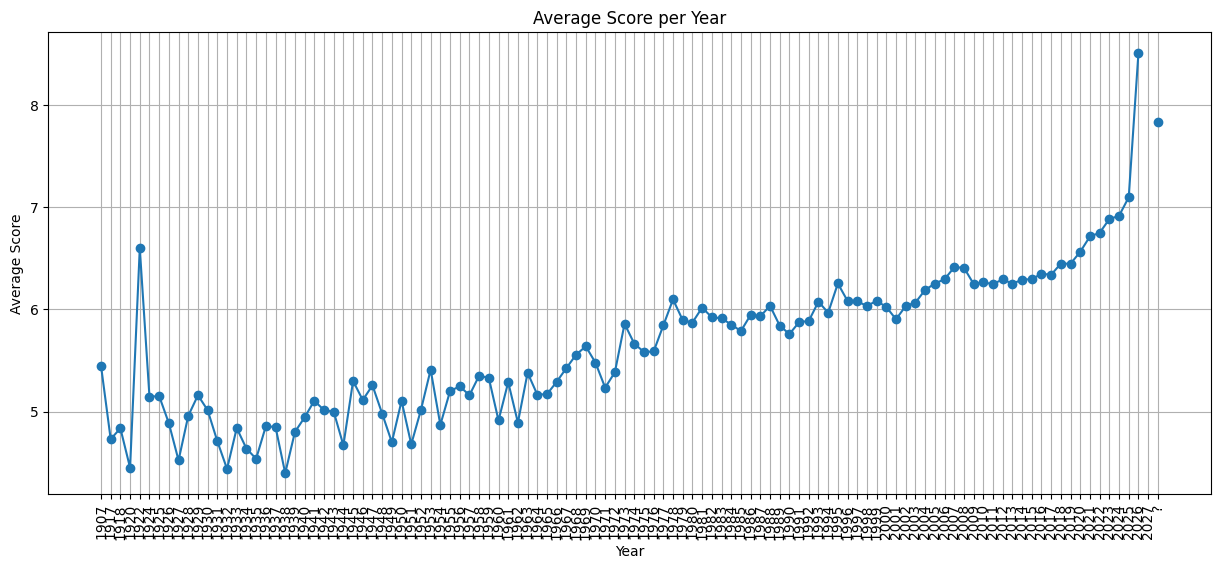

In [18]:
#Implement a score per year avg (to see if there is a trend or if newer anime are better scored)
copy = anime_df.copy()
copy['score'] = pd.to_numeric(copy['score'], errors='coerce')
score_avg_per_year = copy.groupby('year')['score'].mean().reset_index()
print(score_avg_per_year.head())

plt.figure(figsize=(15, 6))
plt.plot(score_avg_per_year['year'], score_avg_per_year['score'], marker='o')
plt.title('Average Score per Year')
plt.xlabel('Year')
plt.ylabel('Average Score')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

Episode Count Statistics:
count    20237.000000
mean        12.746949
std         61.209654
min          0.000000
25%          1.000000
50%          2.000000
75%         12.000000
max       3057.000000
Name: episodes_numeric, dtype: float64


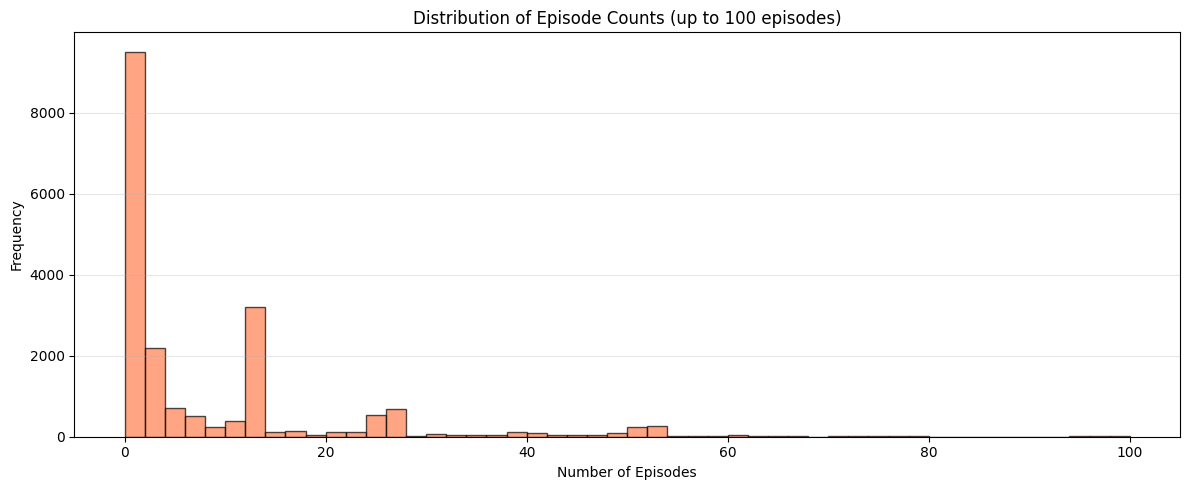


Top 10 Longest Anime (by episode count):
                                                       title  episodes_numeric
                                       3000 Whys Of Blue Cat              3057
                                                  Mrs. Sazae              2805
                                            Nintama Rantarou              2527
                                                  Oyako Club              1818
Kamiusagi Rope: Warau Asa ni wa Fukuraitaru tte Maji ssuka!?              1800
                                                    Doraemon              1787
                                             Prince Mackaroo              1768
                                                The Lazy Egg              1717
                                          Sore Ike! Anpanman              1696
                                      Kirin Monoshiri Yakata              1565


In [20]:
#Episodes Count
anime_df['episodes_numeric'] = pd.to_numeric(anime_df['episodes'], errors='coerce')
episode_stats = anime_df['episodes_numeric'].describe()
print("Episode Count Statistics:")
print(episode_stats)

# Filter out extreme outliers for better visualization
episodes_filtered = anime_df['episodes_numeric'].dropna()
episodes_under_100 = episodes_filtered[episodes_filtered <= 100]

plt.figure(figsize=(12, 5))
plt.hist(episodes_under_100, bins=50, color='coral', edgecolor='black', alpha=0.7)
plt.title('Distribution of Episode Counts (up to 100 episodes)')
plt.xlabel('Number of Episodes')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
# Top 10 longest anime
print("\nTop 10 Longest Anime (by episode count):")
top_longest = anime_df[['title', 'episodes_numeric']].dropna().nlargest(10, 'episodes_numeric')
print(top_longest.to_string(index=False))

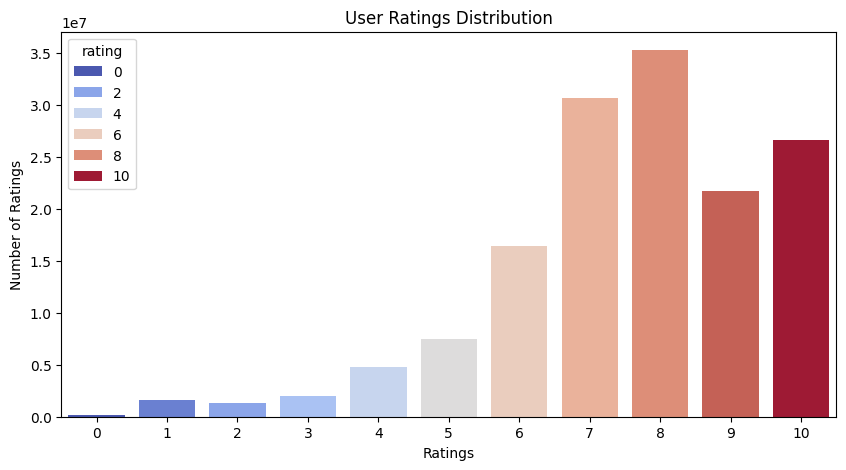

In [19]:
#ratings analysis
ratings_summary = ratings_df['rating'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
sns.barplot(x=ratings_summary.index, y=ratings_summary.values, palette='coolwarm',hue = ratings_summary.index)
plt.title('User Ratings Distribution')
plt.xlabel('Ratings')
plt.ylabel('Number of Ratings')
plt.show()


Average ratings per anime: 7321.76
Median ratings per anime: 264.00
Max ratings for an anime: 956713
Min ratings for an anime: 1


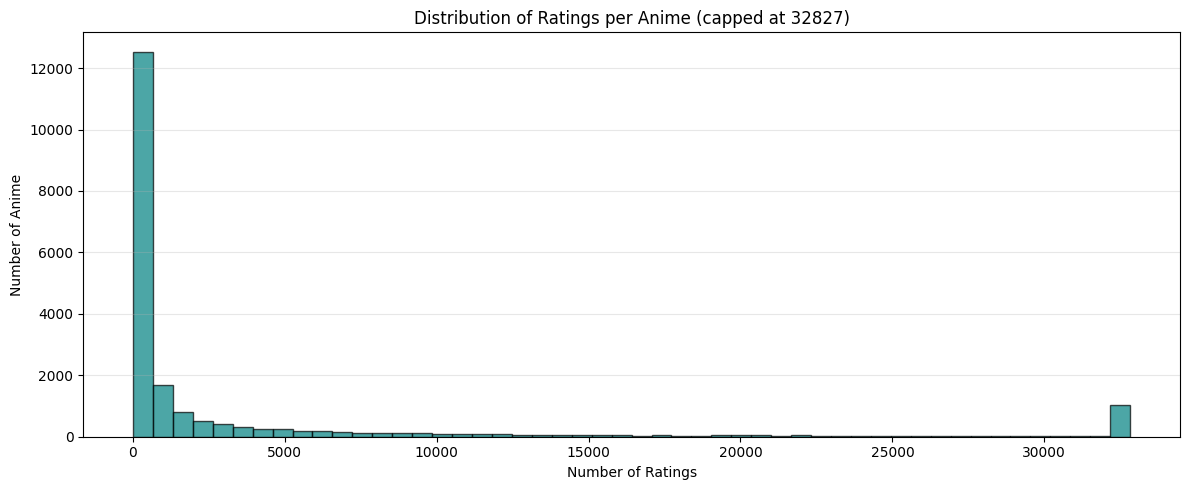

In [ ]:
#Ratings per anime
anime_rating_counts = ratings_df.groupby('anime_id').size()
print(f"Average ratings per anime: {anime_rating_counts.mean():.2f}")
print(f"Median ratings per anime: {anime_rating_counts.median():.2f}")
print(f"Max ratings for an anime: {anime_rating_counts.max()}")
print(f"Min ratings for an anime: {anime_rating_counts.min()}")

#capped at 95th percentile for visualization
cap = anime_rating_counts.quantile(0.95)
plt.figure(figsize=(12, 5))
plt.hist(anime_rating_counts.clip(upper=cap), bins=50, color='teal', edgecolor='black', alpha=0.7)
plt.title(f'Distribution of Ratings per Anime (capped at {int(cap)})')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Anime')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [20]:

#Most rated/popular animes
most_rated = (ratings_df
              .groupby('anime_id')
              .size()
              .reset_index(name='rating_count'))
top_10_most_rated = most_rated.nlargest(10, 'rating_count')
top_10_most_rated = anime_df[anime_df['animeID'].isin(top_10_most_rated['anime_id'])]

In [24]:
print(top_10_most_rated[['title']])

                                 title
1                           Death Note
19                     Attack on Titan
91                       One Punch Man
98    Fullmetal Alchemist: Brotherhood
99                    My Hero Academia
1146                        Your Name.
1159          Attack on Titan Season 2
1166         My Hero Academia Season 2
1185         My Hero Academia Season 3
2375    Demon Slayer: Kimetsu no Yaiba


In [23]:
# Ratings per user distribution
user_rating_counts = ratings_df.groupby('user_id').size()
print(f"Average ratings per user: {user_rating_counts.mean():.2f}")
print(f"Median ratings per user: {user_rating_counts.median():.2f}")

Average ratings per user: 83.50
Median ratings per user: 29.00


Ratings per User Statistics:
Mean: 83.50
Median: 29
25th percentile: 10
75th percentile: 92
90th percentile: 221
Range: [5, 10881]
User Segmentation:
Casual users (<= Q25): 451,621 (25.5%)
Regular users (Q25-Q75): 879,540 (49.6%)
Active users (Q75-Q90): 266,888 (15.0%)
Power users (> Q90): 176,473 (9.9%)


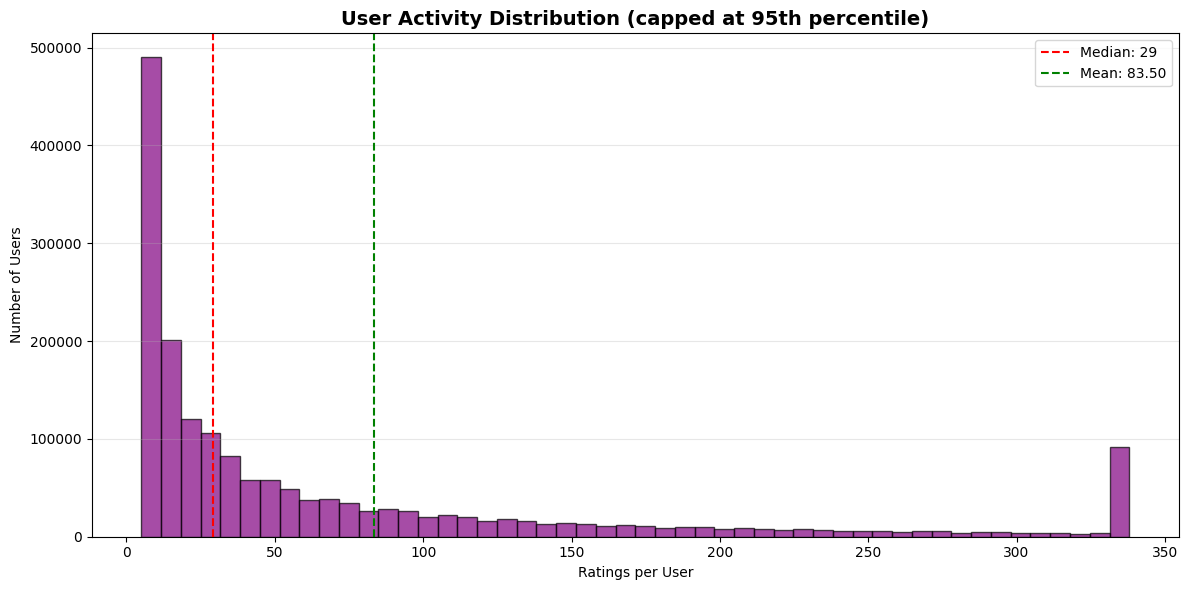

In [42]:
user_counts = Counter(dict(ratings_df["user_id"].value_counts()))
ratings_per_user = pd.Series(list(user_counts.values()))

results = {
    'mean': ratings_per_user.mean(),
    'median': ratings_per_user.median(),
    'q25': ratings_per_user.quantile(0.25),
    'q75': ratings_per_user.quantile(0.75),
    'q90': ratings_per_user.quantile(0.90),
    'min': ratings_per_user.min(),
    'max': ratings_per_user.max()
}

print(f"Ratings per User Statistics:")
print(f"Mean: {results['mean']:.2f}")
print(f"Median: {results['median']:.0f}")
print(f"25th percentile: {results['q25']:.0f}")
print(f"75th percentile: {results['q75']:.0f}")
print(f"90th percentile: {results['q90']:.0f}")
print(f"Range: [{results['min']}, {results['max']}]")

# User segmentation
casual = (ratings_per_user <= results['q25']).sum()
regular = ((ratings_per_user > results['q25']) & (ratings_per_user <= results['q75'])).sum()
active = ((ratings_per_user  > results['q75']) & (ratings_per_user <= results['q90'])).sum()
power = (ratings_per_user > results['q90']).sum()

print(f"User Segmentation:")
print(f"Casual users (<= Q25): {casual:,} ({casual/len(ratings_per_user)*100:.1f}%)")
print(f"Regular users (Q25-Q75): {regular:,} ({regular/len(ratings_per_user)*100:.1f}%)")
print(f"Active users (Q75-Q90): {active:,} ({active/len(ratings_per_user)*100:.1f}%)")
print(f"Power users (> Q90): {power:,} ({power/len(ratings_per_user)*100:.1f}%)")

# Visualize
plt.figure(figsize=(12, 6))
plt.hist(ratings_per_user.clip(upper=ratings_per_user.quantile(0.95)), 
            bins=50, color='purple', edgecolor='black', alpha=0.7)
plt.axvline(results['median'], color='red', linestyle='--', label=f'Median: {results["median"]:.0f}')
plt.axvline(results['mean'], color='green', linestyle='--', label=f'Mean: {results["mean"]:.2f}')
plt.title('User Activity Distribution (capped at 95th percentile)', fontsize=14, fontweight='bold')
plt.xlabel('Ratings per User')
plt.ylabel('Number of Users')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Popularity Statistics:
Total anime with ratings: 20,237
Mean ratings per anime: 7321.76
Median ratings per anime: 264
Pareto Analysis:
Top 1,603 anime (7.9%) account for 80% of all ratings
Top 1% cutoff: 131610 ratings
Top 10% cutoff: 13402 ratings


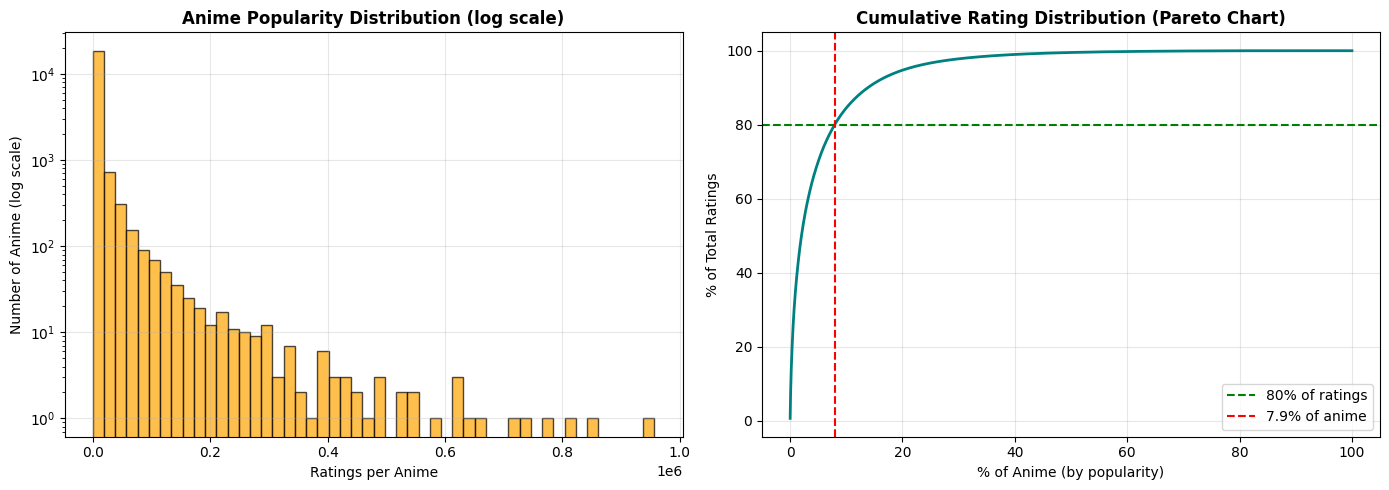

In [45]:
#Identify the "Long Tail"
#Ranks anime by rating count to detect popularity bias.
anime_counts = Counter(dict(ratings_df["anime_id"].value_counts()))
ratings_per_anime = pd.Series(list(anime_counts.values())).sort_values(ascending=False)

# Pareto analysis (80-20 rule)
cumsum = ratings_per_anime.cumsum()
total_ratings = cumsum.iloc[-1]
anime_for_80pct = (cumsum <= 0.8 * total_ratings).sum()

results = {
    'total_anime_with_ratings': len(ratings_per_anime),
    'anime_for_80pct_ratings': anime_for_80pct,
    'pareto_ratio': anime_for_80pct / len(ratings_per_anime),
    'mean_ratings': ratings_per_anime.mean(),
    'median_ratings': ratings_per_anime.median(),
    'top_1pct_cutoff': ratings_per_anime.quantile(0.99),
    'top_10pct_cutoff': ratings_per_anime.quantile(0.90)
}

print(f"Popularity Statistics:")
print(f"Total anime with ratings: {results['total_anime_with_ratings']:,}")
print(f"Mean ratings per anime: {results['mean_ratings']:.2f}")
print(f"Median ratings per anime: {results['median_ratings']:.0f}")

print(f"Pareto Analysis:")
print(f"Top {anime_for_80pct:,} anime ({results['pareto_ratio']*100:.1f}%) account for 80% of all ratings")
print(f"Top 1% cutoff: {results['top_1pct_cutoff']:.0f} ratings")
print(f"Top 10% cutoff: {results['top_10pct_cutoff']:.0f} ratings")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(ratings_per_anime, bins=50, color='orange', edgecolor='black', alpha=0.7)
axes[0].set_yscale('log')
axes[0].set_title('Anime Popularity Distribution (log scale)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Ratings per Anime')
axes[0].set_ylabel('Number of Anime (log scale)')
axes[0].grid(True, alpha=0.3)

# Cumulative distribution
pct_anime = np.arange(1, len(ratings_per_anime) + 1) / len(ratings_per_anime) * 100
pct_ratings = cumsum / total_ratings * 100
axes[1].plot(pct_anime, pct_ratings, color='teal', linewidth=2)
axes[1].axhline(80, color='green', linestyle='--', label='80% of ratings')
axes[1].axvline(results['pareto_ratio']*100, color='red', linestyle='--', 
                label=f'{results["pareto_ratio"]*100:.1f}% of anime')
axes[1].set_title('Cumulative Rating Distribution (Pareto Chart)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('% of Anime (by popularity)')
axes[1].set_ylabel('% of Total Ratings')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Conclusion :**
--
Pareto ratio = 7.9% (too low < 20%) :
- Severe popularity bias detected
- Recommendation system MUST enforce diversity to avoid echo chamber

In [49]:
#Sequels review
sequels = anime_df['sequel'].dropna()   
results = {
    'available': True,
    'total_anime': len(anime_df),
    'anime_with_sequels': (sequels == True).sum(),
}
results['sequel_percentage']= results['anime_with_sequels'] / len(anime_df) * 100

print(f"Sequel Statistics:")
print(f"Anime with sequel links: {results['anime_with_sequels']:,} ({results['sequel_percentage']:.2f}%)")


print(f"Post-Processing Impact:")
print(f"Diversity filter should group {results['anime_with_sequels']:,} sequel relationships")

Sequel Statistics:
Anime with sequel links: 1,053 (5.20%)
Post-Processing Impact:
Diversity filter should group 1,053 sequel relationships


Analyzes sequel relationships if available for post-processing diversity filters.

In [52]:
 # Calculate sparsity
unique_users = ratings_df["user_id"].nunique()
unique_animes = ratings_df["anime_id"].nunique()
total_ratings = len(ratings_df)

possible_interactions = unique_users * unique_animes
sparsity = 1 - (total_ratings / possible_interactions)
density = total_ratings / possible_interactions

results = {
    'unique_users': unique_users,
    'unique_animes': unique_animes,
    'total_ratings': total_ratings,
    'possible_interactions': possible_interactions,
    'sparsity': sparsity,
    'density': density
}

print(f"Matrix Statistics:")
print(f"Unique users: {unique_users:,}")
print(f"Unique anime: {unique_animes:,}")
print(f"Total ratings: {total_ratings:,}")
print(f"Possible interactions: {possible_interactions:,}")
print(f"Sparsity: {sparsity*100:.2f}%")
print(f"Density: {density*100:.4f}%")

Matrix Statistics:
Unique users: 1,774,522
Unique anime: 20,237
Total ratings: 148,170,496
Possible interactions: 35,911,001,714
Sparsity: 99.59%
Density: 0.4126%


- data very sparse > 0.99 ==> Hybrid approach recommended
- Balance content-based and collaborative filtering

Text Corpus Statistics:
Total words (after filtering): 713,796
Unique vocabulary: 48,761
Top 20 Keywords:
 1. world           (4,300)
 2. school          (3,685)
 3. new             (3,390)
 4. life            (3,061)
 5. girl            (2,427)
 6. time            (2,338)
 7. video           (2,309)
 8. music           (2,222)
 9. first           (1,979)
10. young           (1,939)
11. high            (1,896)
12. friends         (1,874)
13. song            (1,842)
14. year            (1,620)
15. help            (1,563)
16. mysterious      (1,498)
17. girls           (1,493)
18. family          (1,463)
19. love            (1,450)
20. earth           (1,420)


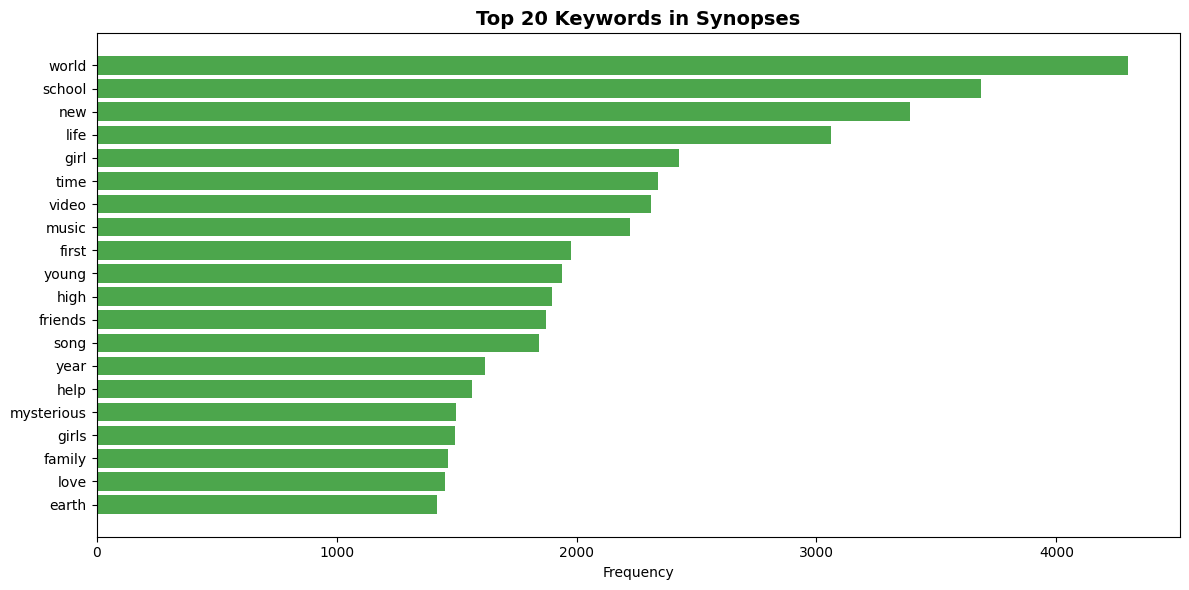

In [14]:
synopses = anime_df['synopsis'].dropna()

all_text = ' '.join(synopses.str.lower())

# Use NLTK for advanced stopword removal

stopwords = set(nltk_stopwords.words('english'))
custom_stopwords = {'anime', 'episode', 'series', 'story', 'characters', 'character', 
                   'one', 'two', 'three', 'now', 'upon', 'even', 'also', 'along',
                   'become', 'find', 'take', 'make', 'get', 'go', 'come', 'see',
                   'know', 'day', 'way', 'back', 'yet', 'still', 'well', 'much',
                   'many', 'more', 'other', 'such', 'own', 'than', 'through',
                   'around', 'between', 'during', 'within', 'without', 'however', 'must','years'}
stopwords.update(custom_stopwords)


words = re.findall(r'\b[a-z]{3,}\b', all_text)  # Words with 3+ letters
filtered_words = [w for w in words if w not in stopwords]


word_freq = Counter(filtered_words)
top_keywords = dict(word_freq.most_common(20))

results = {
    'total_unique_words': len(word_freq),
    'total_words': len(filtered_words),
    'top_keywords': top_keywords
}

print(f"Text Corpus Statistics:")
print(f"Total words (after filtering): {results['total_words']:,}")
print(f"Unique vocabulary: {results['total_unique_words']:,}")

print(f"Top 20 Keywords:")
for i, (word, count) in enumerate(top_keywords.items(), 1):
    print(f"{i:2d}. {word:15s} ({count:,})")

# Visualize
plt.figure(figsize=(12, 6))
words_list = list(top_keywords.keys())
counts_list = list(top_keywords.values())
plt.barh(words_list[::-1], counts_list[::-1], color='green', alpha=0.7)
plt.title(f'Top 20 Keywords in Synopses', fontsize=14, fontweight='bold')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()
    